<a href="https://colab.research.google.com/github/ERKAN3806/imageModel/blob/main/Traffic_Sign.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q ultralytics roboflow supervision

In [ ]:
import os
from roboflow import Roboflow
from ultralytics import YOLO

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import yaml

# === Yollar ===
root = "/content/augmented_filteredDS"
yaml_path = f"{root}/data.yaml"

# YAML dosyasını oku
with open(yaml_path, "r") as f:
    data = yaml.safe_load(f)


old_to_new = {old: i for i, old in enumerate(sorted([int(k) for k in data["names"].keys()]))}

# Yeni isim listesi oluştur
new_names = {new: data["names"][old] for old, new in zip(sorted(old_to_new.keys()), old_to_new.values())}
data["names"] = new_names

# Etiket dosyalarını güncelle
for split in ["train", "val", "test"]:
    lbl_dir = os.path.join(root, split, "labels")
    for file in os.listdir(lbl_dir):
        if not file.endswith(".txt"):
            continue
        path = os.path.join(lbl_dir, file)
        new_lines = []
        with open(path) as f:
            for line in f:
                if not line.strip():
                    continue
                parts = line.split()
                old_id = int(float(parts[0]))
                if old_id in old_to_new:
                    parts[0] = str(old_to_new[old_id])
                    new_lines.append(" ".join(parts) + "\n")

        with open(path, "w") as f:
            f.writelines(new_lines)


with open(yaml_path, "w") as f:
    yaml.dump(data, f, sort_keys=True, allow_unicode=True)

print("✅ Sınıf ID’leri yeniden eşlendi ve data.yaml güncellendi.")
print(f"Yeni sınıf sayısı: {len(new_names)}")
print("Yeni sıralı eşleme:")
print(old_to_new)


✅ Sınıf ID’leri yeniden eşlendi ve data.yaml güncellendi.
Yeni sınıf sayısı: 43
Yeni sıralı eşleme:
{0: 0, 1: 1, 5: 2, 6: 3, 11: 4, 12: 5, 13: 6, 14: 7, 18: 8, 21: 9, 22: 10, 23: 11, 25: 12, 26: 13, 27: 14, 30: 15, 34: 16, 35: 17, 40: 18, 43: 19, 44: 20, 45: 21, 49: 22, 54: 23, 56: 24, 57: 25, 58: 26, 59: 27, 60: 28, 62: 29, 64: 30, 65: 31, 66: 32, 67: 33, 68: 34, 69: 35, 70: 36, 71: 37, 74: 38, 75: 39, 76: 40, 90: 41, 92: 42}


In [ ]:
import os

labels_root = "/content/drive/MyDrive/lastDS"
label_folders = ["train/labels", "val/labels", "test/labels"]


class_counts = {}

for folder in label_folders:
    full_path = os.path.join(labels_root, folder)
    if not os.path.exists(full_path):
        print(f"⚠️ {folder} klasörü bulunamadı, atlanıyor.")
        continue

    for file in os.listdir(full_path):
        if file.endswith(".txt"):
            path = os.path.join(full_path, file)
            with open(path, "r") as f:
                for line in f:
                    if line.strip():
                        try:
                            cid = int(float(line.split()[0]))
                            class_counts[cid] = class_counts.get(cid, 0) + 1
                        except ValueError:
                            print(f"Hatalı satır ({file}): {line.strip()}")


sorted_counts = dict(sorted(class_counts.items(), key=lambda x: x[0]))
print("\n📊 Sınıf ID Dağılımı:")
for cid, count in sorted_counts.items():
    print(f"Class {cid}: {count} örnek")

print("\nToplam sınıf sayısı:", len(sorted_counts))



📊 Sınıf ID Dağılımı:
Class 0: 33 örnek
Class 1: 711 örnek
Class 2: 9 örnek
Class 5: 324 örnek
Class 6: 101 örnek
Class 7: 3 örnek
Class 9: 5 örnek
Class 10: 6 örnek
Class 11: 34 örnek
Class 12: 1422 örnek
Class 13: 13 örnek
Class 14: 1105 örnek
Class 18: 148 örnek
Class 20: 1 örnek
Class 21: 1262 örnek
Class 22: 23 örnek
Class 23: 283 örnek
Class 25: 640 örnek
Class 26: 34 örnek
Class 27: 176 örnek
Class 30: 1318 örnek
Class 34: 98 örnek
Class 35: 13 örnek
Class 40: 1363 örnek
Class 41: 3 örnek
Class 43: 90 örnek
Class 44: 233 örnek
Class 45: 689 örnek
Class 47: 8 örnek
Class 49: 101 örnek
Class 53: 10 örnek
Class 54: 44 örnek
Class 56: 590 örnek
Class 57: 331 örnek
Class 58: 24 örnek
Class 59: 179 örnek
Class 60: 516 örnek
Class 61: 6 örnek
Class 62: 108 örnek
Class 63: 5 örnek
Class 64: 19 örnek
Class 65: 42 örnek
Class 66: 64 örnek
Class 67: 1416 örnek
Class 68: 1036 örnek
Class 69: 49 örnek
Class 70: 77 örnek
Class 71: 72 örnek
Class 72: 12 örnek
Class 73: 11 örnek
Class 74: 565 ö

In [ ]:
import os
import shutil
import cv2
import albumentations as A
from tqdm import tqdm


drive_root = "/content/drive/MyDrive/lastDS"
safe_root = "/content/augmented_filteredDS"
os.makedirs(safe_root, exist_ok=True)

splits = ["train", "val", "test"]

for sp in splits:
    for sub in ["images", "labels"]:
        src = f"{drive_root}/{sp}/{sub}"
        dst = f"{safe_root}/{sp}/{sub}"
        os.makedirs(dst, exist_ok=True)
        for f in os.listdir(src):
            shutil.copy(os.path.join(src, f), os.path.join(dst, f))


class_counts = {}
for sp in splits:
    lbl_dir = f"{safe_root}/{sp}/labels"
    for file in os.listdir(lbl_dir):
        if file.endswith(".txt"):
            with open(os.path.join(lbl_dir, file)) as f:
                for line in f:
                    if line.strip():
                        cid = int(float(line.split()[0]))
                        class_counts[cid] = class_counts.get(cid, 0) + 1


to_remove = [cid for cid, count in class_counts.items() if count < 13]
print(f"🚫 Kaldırılacak sınıflar: {to_remove}")

for sp in splits:
    img_dir = f"{safe_root}/{sp}/images"
    lbl_dir = f"{safe_root}/{sp}/labels"
    for file in os.listdir(lbl_dir):
        if not file.endswith(".txt"): continue
        path = os.path.join(lbl_dir, file)
        with open(path, "r") as f:
            lines = f.readlines()
        keep = []
        for line in lines:
            if line.strip():
                cid = int(float(line.split()[0]))
                if cid not in to_remove:
                    keep.append(line)
        if keep:
            with open(path, "w") as f:
                f.writelines(keep)
        else:

            os.remove(path)
            img_path = os.path.join(img_dir, file.replace(".txt", ".jpg"))
            if os.path.exists(img_path): os.remove(img_path)
            img_path = os.path.join(img_dir, file.replace(".txt", ".png"))
            if os.path.exists(img_path): os.remove(img_path)


class_counts = {}
for sp in splits:
    lbl_dir = f"{safe_root}/{sp}/labels"
    for file in os.listdir(lbl_dir):
        if file.endswith(".txt"):
            with open(os.path.join(lbl_dir, file)) as f:
                for line in f:
                    if line.strip():
                        cid = int(float(line.split()[0]))
                        class_counts[cid] = class_counts.get(cid, 0) + 1
print(f"📊 Güncel sınıf örnek sayıları: {class_counts}")


augmentor = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.3),
    A.Rotate(limit=15, p=0.5),
    A.Blur(blur_limit=3, p=0.2)
])

for sp in ["train"]:
    img_dir = f"{safe_root}/{sp}/images"
    lbl_dir = f"{safe_root}/{sp}/labels"
    target_min = 50
    for cid, count in class_counts.items():
        if count < target_min:
            need = target_min - count
            print(f"🔼 Sınıf {cid} için {need} yeni görsel üretiliyor...")
            generated = 0
            for file in os.listdir(lbl_dir):
                if not file.endswith(".txt"): continue
                path = os.path.join(lbl_dir, file)
                with open(path) as f:
                    lines = f.readlines()
                cids = [int(float(l.split()[0])) for l in lines if l.strip()]
                if cid in cids:
                    img_path = os.path.join(img_dir, file.replace(".txt", ".jpg"))
                    if not os.path.exists(img_path):
                        img_path = img_path.replace(".jpg", ".png")
                    if not os.path.exists(img_path): continue

                    img = cv2.imread(img_path)
                    aug = augmentor(image=img)
                    new_img = aug["image"]
                    new_name = file.replace(".txt", f"_aug{generated}.jpg")
                    cv2.imwrite(os.path.join(img_dir, new_name), new_img)
                    shutil.copy(path, os.path.join(lbl_dir, new_name.replace(".jpg", ".txt")))
                    generated += 1
                    if generated >= need: break

print("\n✅ İşlem tamamlandı. Yeni veri seti:", safe_root)


🚫 Kaldırılacak sınıflar: [73, 72, 61, 9, 53, 41, 78, 47, 2, 10, 63, 7, 20]
📊 Güncel sınıf örnek sayıları: {1: 711, 56: 590, 21: 1262, 68: 1036, 40: 1363, 30: 1318, 45: 689, 74: 565, 12: 1422, 57: 331, 67: 1416, 18: 148, 44: 233, 14: 1105, 0: 33, 60: 516, 25: 640, 27: 176, 23: 283, 5: 324, 71: 72, 6: 101, 65: 42, 62: 108, 59: 179, 13: 13, 34: 98, 75: 45, 49: 101, 26: 34, 70: 77, 66: 64, 11: 34, 69: 49, 43: 90, 90: 13, 58: 24, 64: 19, 35: 13, 54: 44, 22: 23, 76: 31, 92: 19}
🔼 Sınıf 0 için 17 yeni görsel üretiliyor...
🔼 Sınıf 65 için 8 yeni görsel üretiliyor...
🔼 Sınıf 13 için 37 yeni görsel üretiliyor...
🔼 Sınıf 75 için 5 yeni görsel üretiliyor...
🔼 Sınıf 26 için 16 yeni görsel üretiliyor...
🔼 Sınıf 11 için 16 yeni görsel üretiliyor...
🔼 Sınıf 69 için 1 yeni görsel üretiliyor...
🔼 Sınıf 90 için 37 yeni görsel üretiliyor...
🔼 Sınıf 58 için 26 yeni görsel üretiliyor...
🔼 Sınıf 64 için 31 yeni görsel üretiliyor...
🔼 Sınıf 35 için 37 yeni görsel üretiliyor...
🔼 Sınıf 54 için 6 yeni görsel ür

In [ ]:
#hatalı etiketleri kaldır
import os
from pathlib import Path

root = Path("/content/augmented_filteredDS")
splits = ["train", "val", "test"]

def is_label_corrupt(label_path):
    with open(label_path, "r") as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) != 5:
                return True
            try:
                _, x, y, w, h = parts
                x, y, w, h = map(float, [x, y, w, h])
                if not (0 <= x <= 1 and 0 <= y <= 1 and 0 <= w <= 1 and 0 <= h <= 1):
                    return True
            except ValueError:
                return True
    return False

removed = []
for split in splits:
    lbl_dir = root / split / "labels"
    img_dir = root / split / "images"

    for file in lbl_dir.glob("*.txt"):
        if is_label_corrupt(file):
            img_file_jpg = img_dir / (file.stem + ".jpg")
            img_file_png = img_dir / (file.stem + ".png")

            # Dosyaları kaldır
            os.remove(file)
            if img_file_jpg.exists():
                os.remove(img_file_jpg)
            elif img_file_png.exists():
                os.remove(img_file_png)

            removed.append(file.name)
            print(f"🗑️ Kaldırıldı: {file.name}")

print(f"\n✅ Toplam {len(removed)} bozuk etiket dosyası kaldırıldı.")


🗑️ Kaldırıldı: ITU_ITU755.txt
🗑️ Kaldırıldı: ITU_ITU1230.txt
🗑️ Kaldırıldı: ITU_ITU11.txt
🗑️ Kaldırıldı: ITU_ITU475.txt
🗑️ Kaldırıldı: ITU_ITU645.txt
🗑️ Kaldırıldı: ITU_ITU558.txt
🗑️ Kaldırıldı: ITU_ITU702.txt
🗑️ Kaldırıldı: ITU_ITU140.txt
🗑️ Kaldırıldı: ITU_ITU1110.txt
🗑️ Kaldırıldı: ITU_ITU573.txt
🗑️ Kaldırıldı: ITU_ITU979.txt
🗑️ Kaldırıldı: ITU_ITU329.txt
🗑️ Kaldırıldı: ITU_ITU1052.txt
🗑️ Kaldırıldı: ITU_ITU1012.txt
🗑️ Kaldırıldı: ITU_ITU917.txt
🗑️ Kaldırıldı: ITU_ITU1112.txt
🗑️ Kaldırıldı: ITU_ITU382.txt
🗑️ Kaldırıldı: ITU_ITU231.txt
🗑️ Kaldırıldı: ITU_ITU1174.txt
🗑️ Kaldırıldı: ITU_ITU521.txt
🗑️ Kaldırıldı: ITU_ITU691.txt
🗑️ Kaldırıldı: ITU_ITU688.txt
🗑️ Kaldırıldı: ITU_ITU178.txt
🗑️ Kaldırıldı: ITU_ITU544.txt
🗑️ Kaldırıldı: ITU_ITU390.txt
🗑️ Kaldırıldı: ITU_ITU141.txt
🗑️ Kaldırıldı: ITU_ITU335.txt
🗑️ Kaldırıldı: ITU_ITU315.txt
🗑️ Kaldırıldı: ITU_ITU928.txt
🗑️ Kaldırıldı: ITU_ITU425.txt
🗑️ Kaldırıldı: ITU_ITU1048.txt
🗑️ Kaldırıldı: ITU_ITU209.txt
🗑️ Kaldırıldı: ITU_ITU132.txt
🗑️ K

In [ ]:

from ultralytics import YOLO


model = YOLO("yolov9c.pt")

# Eğitim
results = model.train(
    data=f"/content/augmented_filteredDS/data.yaml",
    epochs=180,
    imgsz=1000,
    batch=32,
    workers=2,
    device=0,
    name="traffic",
    optimizer='AdamW',
    dropout=0.05,
    lr0=0.002,
    lrf=0.1,
    momentum=0.9,
    weight_decay=0.0005,
    warmup_epochs=3,
    amp=True,
    cache=True,
    patience=20,
    save_period=5,
    cos_lr=True,
)



Ultralytics 8.3.223 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (NVIDIA A100-SXM4-80GB, 81222MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=True, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=/content/augmented_filteredDS/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.05, dynamic=False, embed=None, epochs=180, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=1000, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.002, lrf=0.1, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov9c.pt, momentum=0.9, mosaic=1.0, multi_scale=False, name=traffic2, nbs=64, nms=False, opset=None, optimize=False, optimizer=AdamW, overlap_mask=True, patience=20, perspective=

In [ ]:
# devam etme

from ultralytics import YOLO


model = YOLO("/content/runs/detect/traffic_finetune6/weights/last.pt")

# Fine-tuning
results = model.train(
    data="/content/augmented_filteredDS/data.yaml",
    epochs=17,
    lr0=0.0007,
    imgsz=1024,
    batch=32,
    device=0,
    optimizer="AdamW",
    dropout=0.01,
    cos_lr=True,
    patience=15,
    name="traffic_finetune",
    cache=True
)


Ultralytics 8.3.223 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (NVIDIA A100-SXM4-80GB, 81222MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=True, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=/content/augmented_filteredDS/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.01, dynamic=False, embed=None, epochs=17, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=1024, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0007, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=/content/runs/detect/traffic_finetune6/weights/last.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=traffic_finetune7, nbs=64, nms=False, opset=None, optimize=False, optim

In [ ]:

import os, glob
from google.colab import files


run_dir = "/content/runs/detect/traffic2"
best_path = os.path.join(run_dir, "weights", "last.pt")

if not os.path.exists(best_path):

    run_dir = max(glob.glob("/content/runs/detect/*"), key=os.path.getmtime)
    best_path = os.path.join(run_dir, "weights", "last.pt")

print("İndirilecek dosya:", best_path)
files.download(best_path)


In [ ]:

import os, glob
from google.colab import files


run_dir = "/content/runs/detect/traffic2"
best_path = os.path.join(run_dir, "weights", "best.pt")

if not os.path.exists(best_path):
    run_dir = max(glob.glob("/content/runs/detect/*"), key=os.path.getmtime)
    best_path = os.path.join(run_dir, "weights", "last.pt")

print("İndirilecek dosya:", best_path)
files.download(best_path)


İndirilecek dosya: /content/runs/detect/traffic2/weights/best.pt


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


WARNING ⚠️ 
inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

image 1/1107 /content/drive/MyDrive/lastDS/test/images/ACA_ACAR_000070.jpg: 384x640 1 Kırmızı Işık, 120.0ms
image 2/1107 /content/drive/MyDrive/lastDS/test/images/ACA_ACAR_000080.jpg: 384x640 (no detections), 17.8ms
image 3/1107 /content/drive/MyDrive/lastDS/test/images/ACA_ACAR_000098.jpg: 384x640 1 Azami Hız Sınırlaması 30, 17.9ms
image 4/1107 /content/drive/MyDrive/lastDS/test/images/ACA_ACAR_000100.jpg: 384x640 1 Duraklamak ve Park Etmek Yasaktır, 

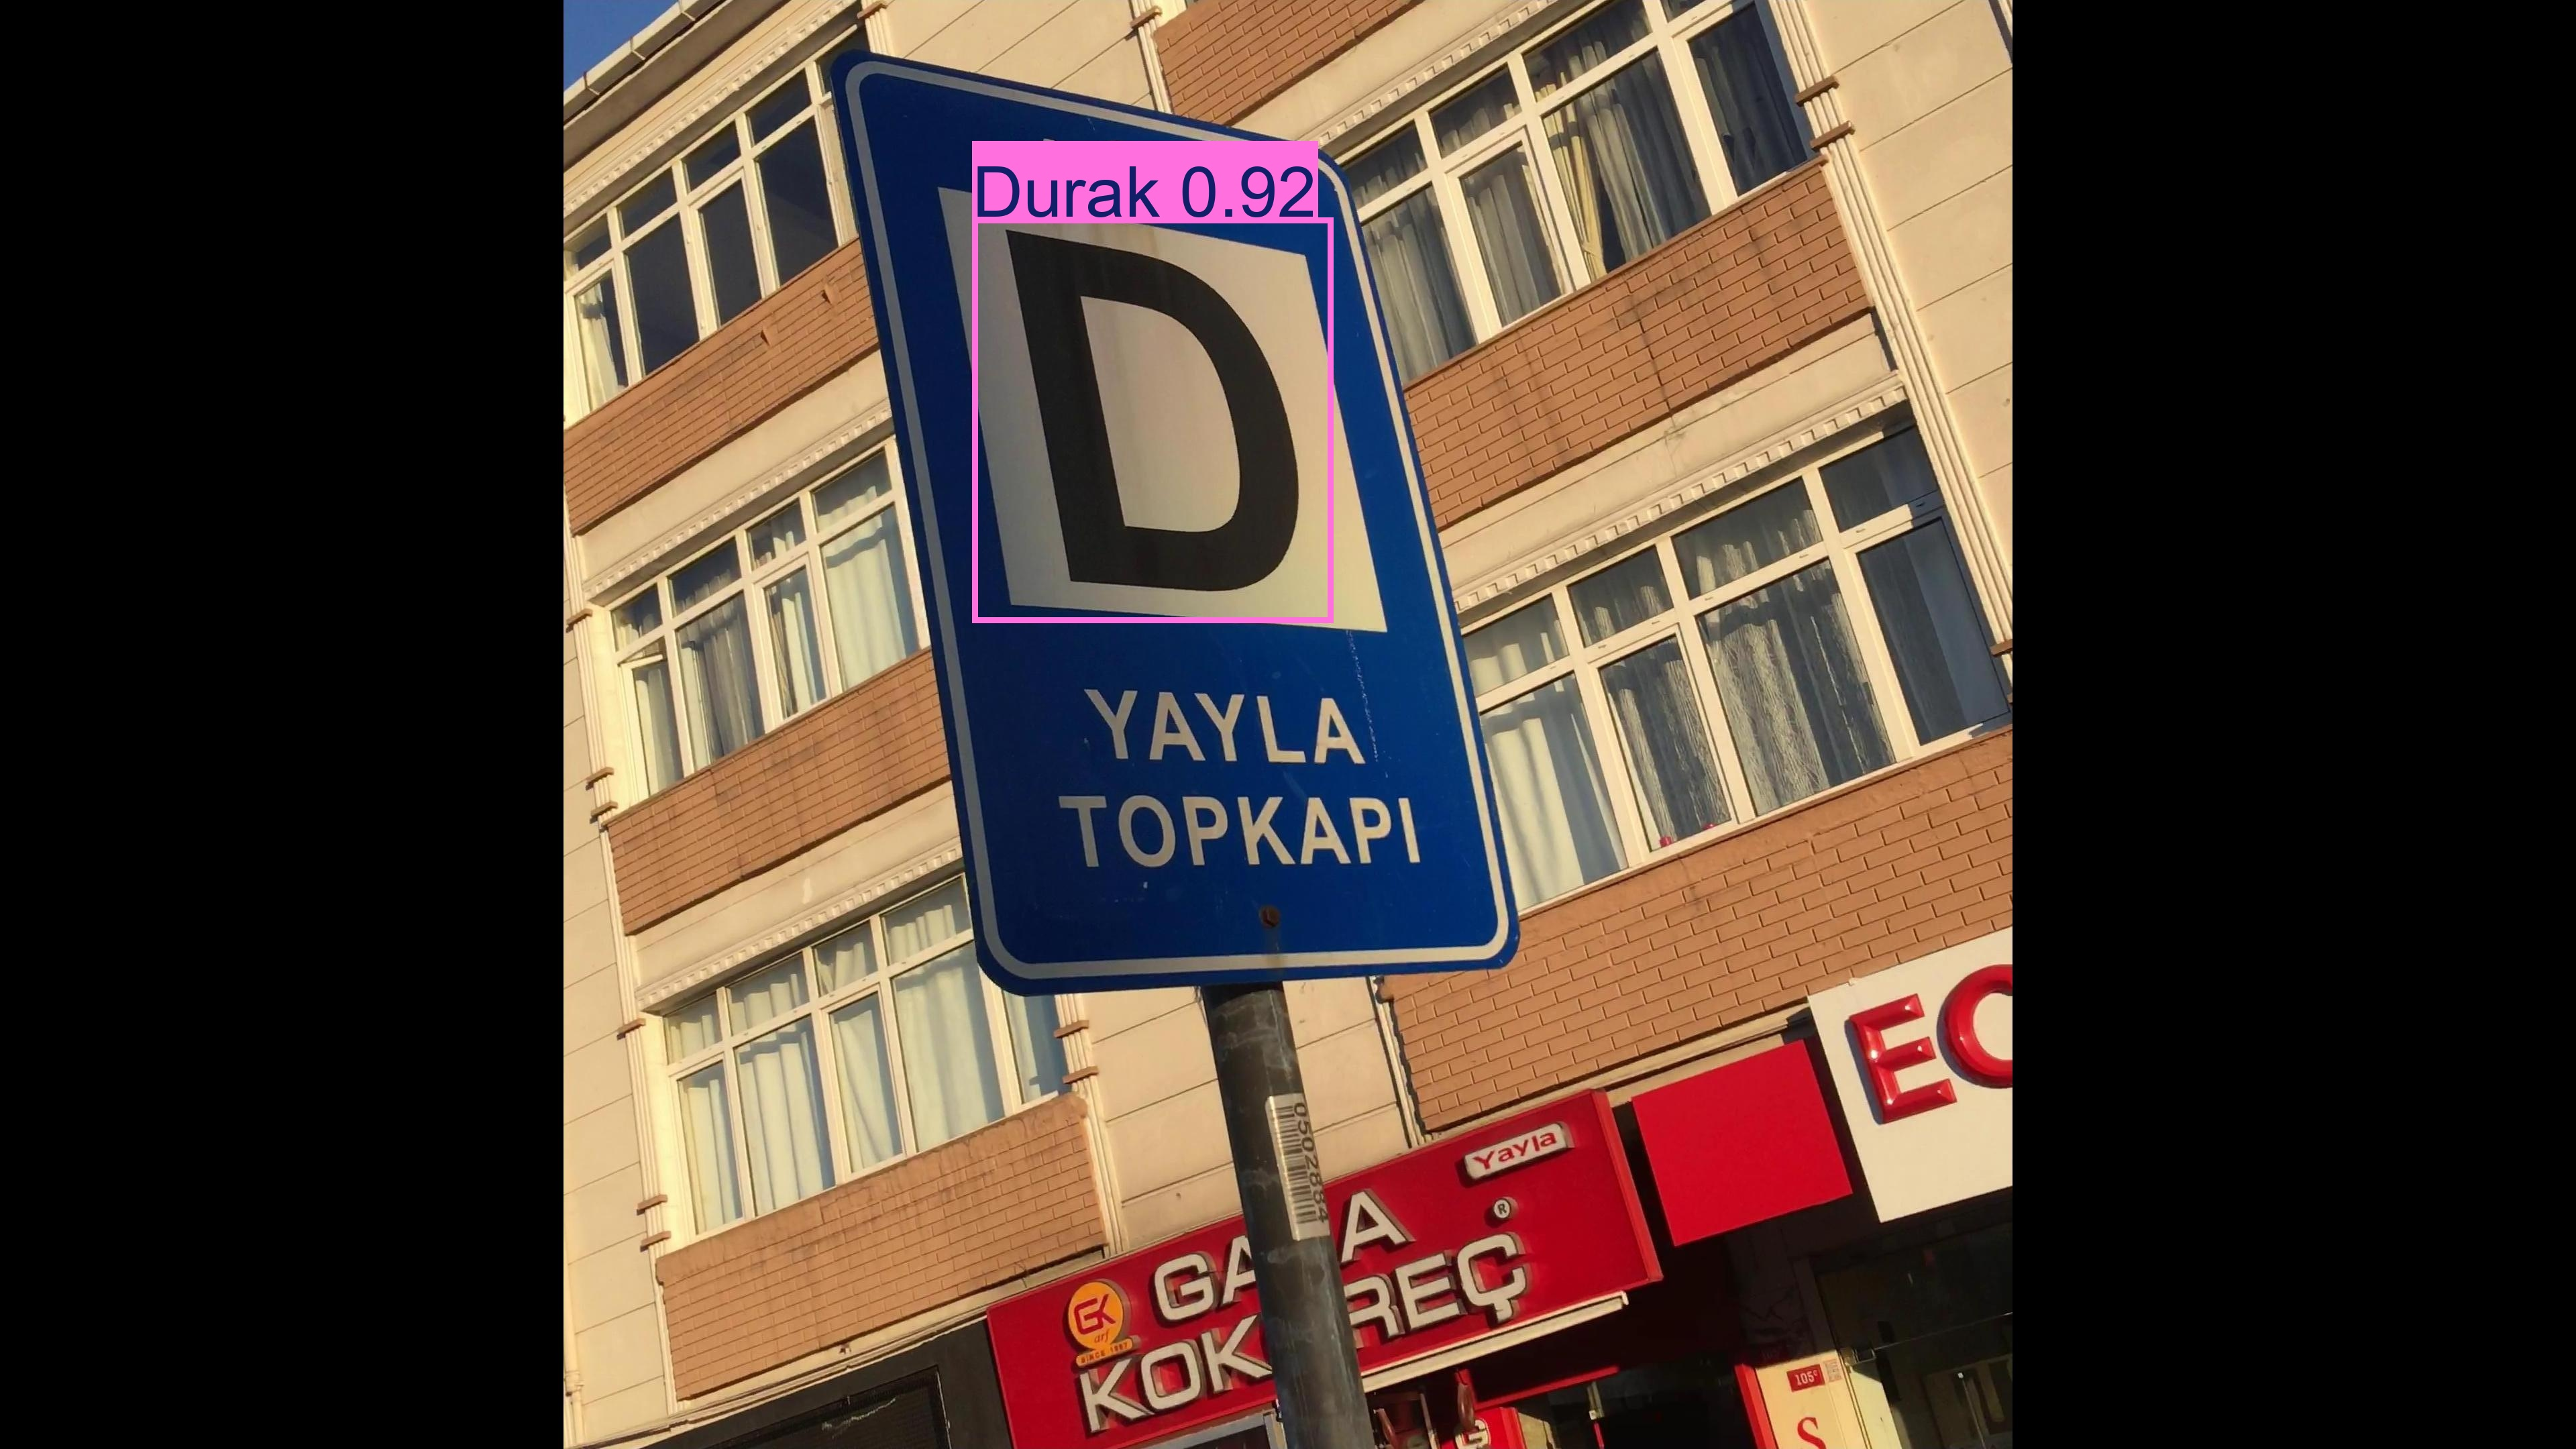

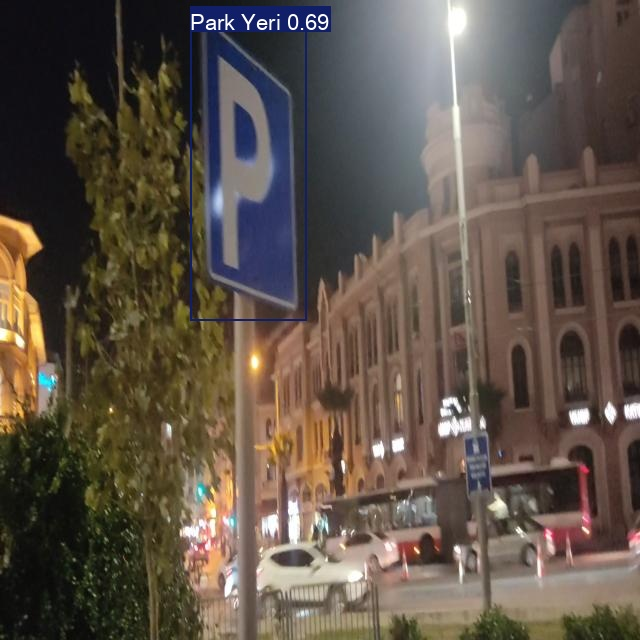

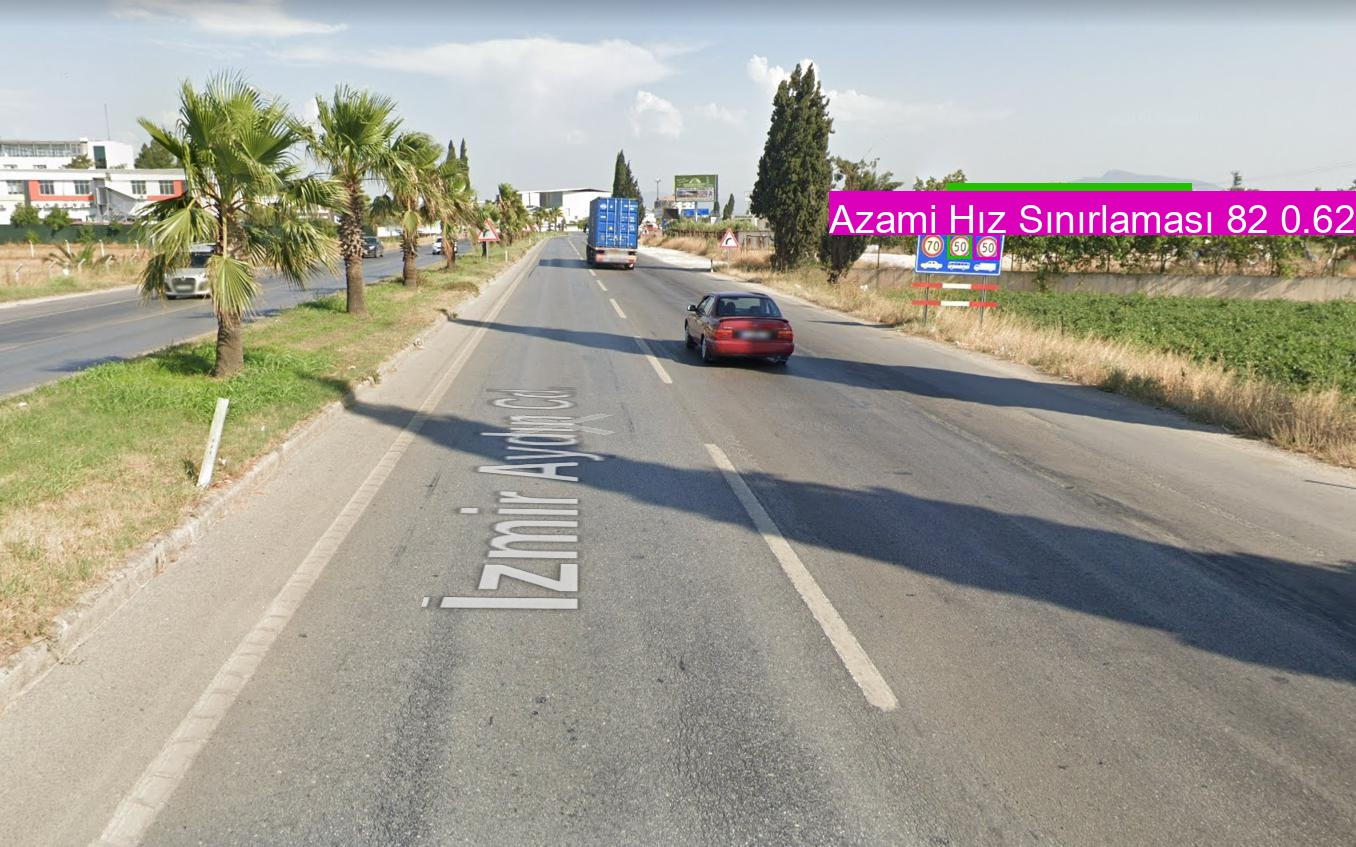

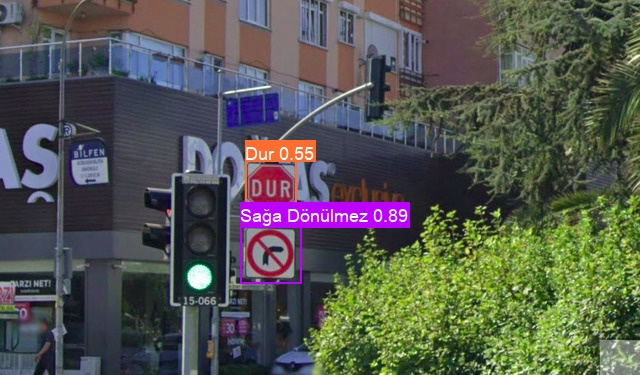

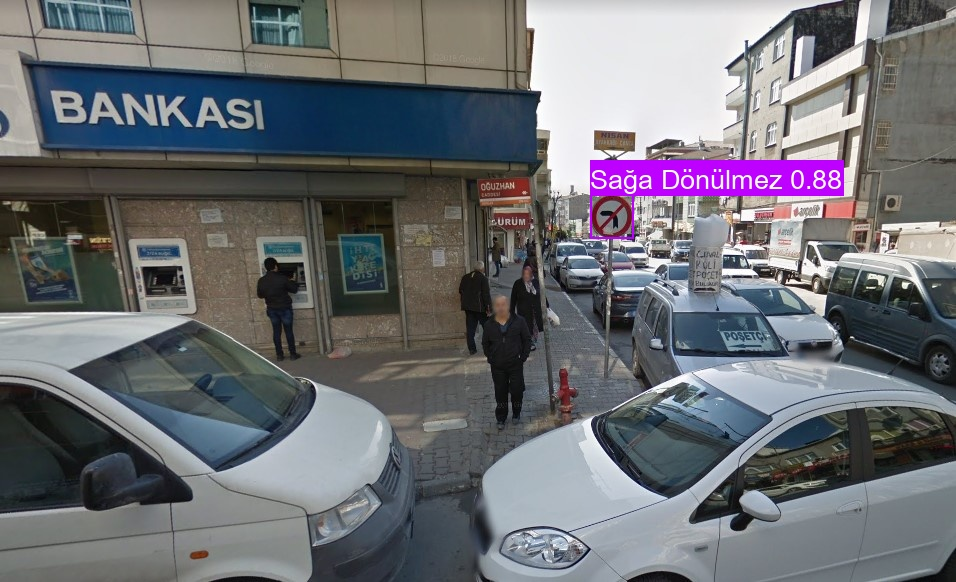

In [ ]:

from ultralytics import YOLO
from IPython.display import Image, display
import glob, os


model = YOLO("/content/runs/detect/traffic_finetune7/weights/last.pt")


test_dir = "/content/drive/MyDrive/lastDS/test/images"


results = model.predict(
    source=test_dir,
    imgsz=640,
    conf=0.25,
    iou=0.45,
    save=True,
    save_txt=True,
    project="/content/runs/detect",
    name="traffic_test_results",
    exist_ok=True,
    show_labels=True,
    show_conf=True,
    device=0
)


output_dir = "/content/runs/detect/traffic_test_results"

print(f"✅ Tahminler tamamlandı. Sonuçlar burada kaydedildi:\n{output_dir}")


pred_images = glob.glob(os.path.join(output_dir, "*.jpg"))
print(f"{len(pred_images)} adet görsel işlendi.")

for img_path in pred_images[:5]:
    display(Image(filename=img_path))


In [ ]:
"""import torch, gc, os, IPython

import gc, torch

# Varsa sil, yoksa atla
for var in ["model", "results"]:
    if var in locals():
        del globals()[var]

gc.collect()
torch.cuda.empty_cache()
print("GPU belleği boşaltıldı ✅")




GPU belleği boşaltıldı ✅


In [ ]:
best_model = YOLO("/content/runs/detect/buildingdamage_yolov9/weights/last.pt")

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ultralytics import YOLO

metrics = best_model.val()


precision = float(np.mean(metrics.box.p))
recall = float(np.mean(metrics.box.r))
f1 = 2 * (precision * recall) / (precision + recall + 1e-16)

print("\n📊 Genel Model Performans Metrikleri:")
print(f"Precision (ortalama): {precision:.4f}")
print(f"Recall (ortalama):    {recall:.4f}")
print(f"F1 Score:             {f1:.4f}")
print(f"mAP@0.5:              {metrics.box.map50:.4f}")
print(f"mAP@0.75:             {metrics.box.map75:.4f}")
print(f"mAP@0.5:0.95:         {metrics.box.map:.4f}")


In [ ]:

plt.figure(figsize=(12,6))
plt.plot(df['epoch'], df['train/box_loss'], label="Train Box Loss")
plt.plot(df['epoch'], df['train/cls_loss'], label="Train Class Loss")
plt.plot(df['epoch'], df['train/dfl_loss'], label="Train DFL Loss")
plt.plot(df['epoch'], df['val/box_loss'], label="Val Box Loss", linestyle="--")
plt.plot(df['epoch'], df['val/cls_loss'], label="Val Class Loss", linestyle="--")
plt.plot(df['epoch'], df['val/dfl_loss'], label="Val DFL Loss", linestyle="--")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("📉 Eğitim ve Doğrulama Loss Eğrileri")
plt.legend()
plt.show()



In [ ]:

plt.figure(figsize=(12,6))
plt.plot(df['epoch'], df['metrics/precision(B)'], label="Precision")
plt.plot(df['epoch'], df['metrics/recall(B)'], label="Recall")
plt.plot(df['epoch'], df['metrics/mAP50(B)'], label="mAP@0.5")
plt.plot(df['epoch'], df['metrics/mAP50-95(B)'], label="mAP@0.5:0.95")
plt.xlabel("Epoch")
plt.ylabel("Metric Value")
plt.title("📈 Performans Metrikleri (Accuracy)")
plt.legend()
plt.show()


In [ ]:
print("✅ Eğitim ve test tamamlandı. Sonuçlar 'runs/detect/predict/' klasörüne kaydedildi.")


for r in results_test:
    im = r.plot()
    plt.imshow(im[..., ::-1])
    plt.axis("off")
    plt.show()
